# **Tutorial de uso - Neurokit2**

Realizado por:
- Natalia Arenas
- Daniel Barrera
- Sergio Andres Daza

 NeuroKit2 es una biblioteca de Python diseñada para facilitar el análisis de señales fisiológicas como ECG, EDA, EMG y otras. Ofrece herramientas avanzadas para el preprocesamiento, extracción de características y visualización de datos, siendo especialmente útil en investigaciones científicas y aplicaciones biomédicas [1]. Su enfoque es proporcionar resultados precisos con una interfaz simple y amigable para usuarios de distintos niveles de experiencia. Este notebook presenta una introducción al uso de NeuroKit2, con un enfoque específico en el procesamiento y análisis de señales ECG.

Para comenzar a usar la herramienta es necesario realizar la instalacion de la libreria, esto se hace simplemente ejecutando el siguiente comando en la terminal o en una celda del notebook en el que se esta trabajando:

In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 8.5 MB/s eta 0:00:00


Una vez instalada la libreria, solo basta con importarla para usar todas las funcionalidades que ofrece

In [ ]:
import neurokit2 as nk

El propósito a continuación es presentar una serie de ejemplos prácticos que ilustran el uso de diversas funciones de NeuroKit2 para el análisis y procesamiento de señales ECG. Por lo cual se importan algunas de las librerias que se van a utilizar en el desarrollo de este tutorial.

In [ ]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Simulacion de senales fisiologicas artificiales

Las funciones principales de procesamiento de señales de NeuroKit2 están diseñadas para trabajar con datos de electrocardiograma (ECG), respiración (RSP), actividad electrodermal (EDA) y electromiografía (EMG). Este ejemplo muestra cómo utilizar NeuroKit2 para simular estas señales fisiológicas con control paramétrico personalizado, permitiendo ajustar diversas características de las señales según sea necesario.

Con la función `ecg_simulate()` de NeuroKit2, puedes generar una señal de ECG artificial con una duración específica (en este caso, `duration=10`), además de ajustar parámetros como el nivel de ruido y la frecuencia cardíaca. Como se observa en el gráfico a continuación, la señal `ecg50` tiene aproximadamente la mitad de latidos cardíacos que `ecg100`, y también presenta un mayor nivel de ruido en comparación con esta última.

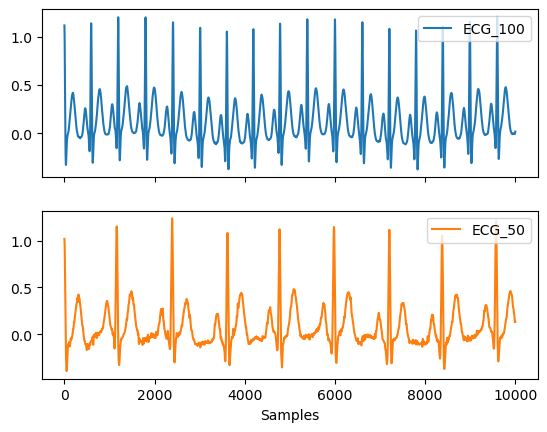

In [ ]:
# Alternate heart rate and noise levels
ecg50 = nk.ecg_simulate(duration=10, noise=0.05, heart_rate=50)
ecg100 = nk.ecg_simulate(duration=10, noise=0.01, heart_rate=100)

# visualizacion
ecg_df = pd.DataFrame({"ECG_100": ecg100, "ECG_50": ecg50})

nk.signal_plot(ecg_df, subplots=True) # Cuenta con su propio plotter

También puedes optar por generar una simulación simple por defecto, basada en wavelets **Daubechies**, que aproxima de manera general un ciclo cardíaco. Alternativamente, puedes crear una simulación más compleja especificando el parámetro `method="ecgsyn"`

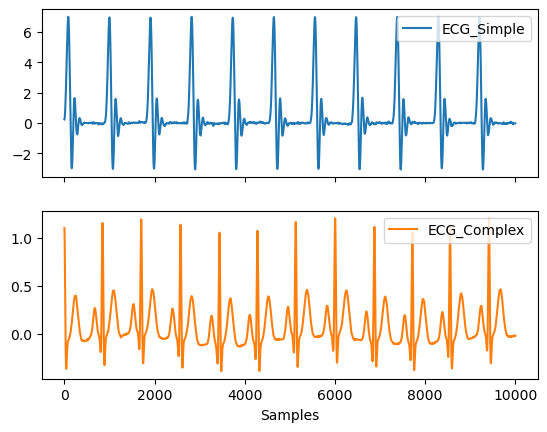

In [ ]:
# Alternate methods
ecg_sim = nk.ecg_simulate(duration=10, method="simple")
ecg_com = nk.ecg_simulate(duration=10, method="ecgsyn")

# Visualizacion
methods = pd.DataFrame({"ECG_Simple": ecg_sim, "ECG_Complex": ecg_com})
nk.signal_plot(methods, subplots=True)

Tambien es posible simular las 12 derivaciones del ECG

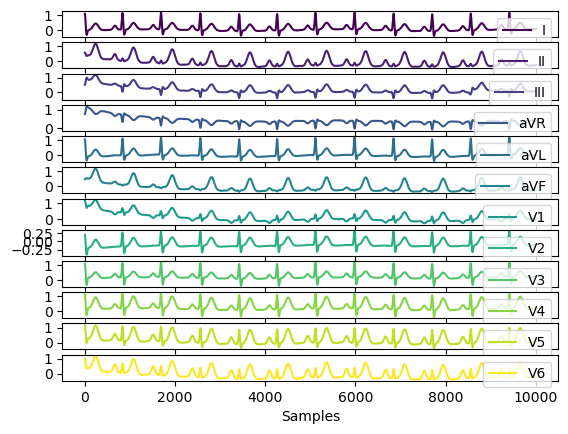

In [ ]:
ecg12 = nk.ecg_simulate(duration=10, method="multileads")

# Visualizacion
nk.signal_plot(ecg12, subplots=True)

## 2. Localizacion de los picos en las señales ECG

Se puede identificar y localizar los componentes del complejo QRS, como los picos P y T, así como sus inicios y finales, utilizando la función `ecg_peaks()`.

Por ejemplo, esta función devuelve un diccionario que contiene las muestras en las que se encuentran los picos R en la señal ECG.

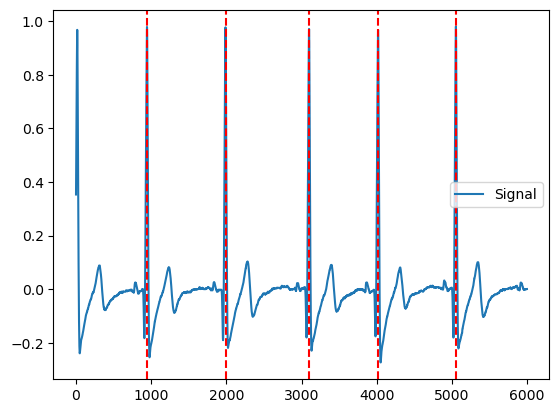

In [ ]:
# ECG data
ecg_signal = nk.data(dataset="ecg_1000hz")
# Picos R
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=1000)

# Visualizacion
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:5], ecg_signal[:6000])

NeuroKit2 tambien permite segmentar y analizar los complejos QRS de una señal ECG utilizando la función `ecg_delineate()`. Esto incluye identificar las ondas P, Q, S y T, junto con sus puntos de inicio y final.

**Métodos disponibles en `ecg_delineate()`:**

- Método de derivadas: Basado en el cálculo de la derivada para segmentar las ondas.
- Método basado en Wavelets: Utiliza transformadas Wavelet para una segmentación más detallada y robusta.

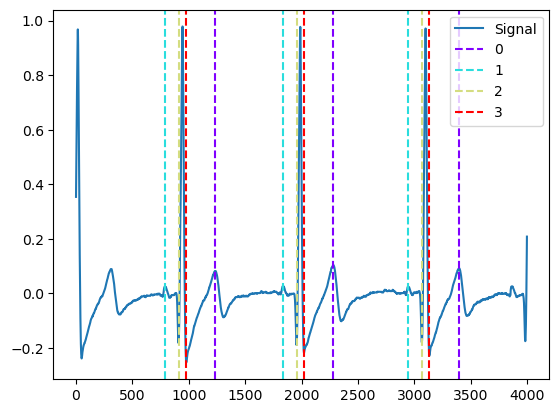

In [ ]:
_, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=1000, method="peak")

plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3],
                       waves_peak['ECG_P_Peaks'][:3],
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3]], ecg_signal[:4000])

Para tener una vista general de todos los complejos al mismo tiempo, se puede usar el argumento `show=True`. Esto genera una visualización que superpone las ondas detectadas sobre la señal ECG, lo que facilita la validación de la segmentación y permite evaluar rápidamente la precisión del método aplicado.

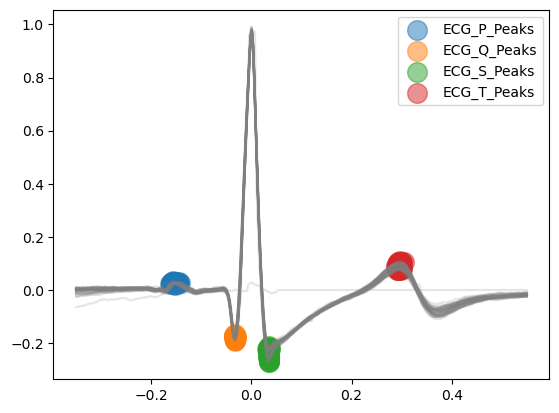

In [ ]:
_, waves_peak = nk.ecg_delineate(ecg_signal,
                                 rpeaks,
                                 sampling_rate=1000,
                                 method="peak",
                                 show=True,
                                 show_type='peaks')

## 3. Limpieza de las señales ECG

La función `ecg_clean` mejora la calidad de las señales ECG al eliminar ruido, lo que optimiza la detección de picos. Permite elegir entre varios métodos de limpieza:

- `neurokit` (predeterminado): Filtro Butterworth de paso alto (0.5 Hz, orden 5), seguido de filtrado de línea de energía (por defecto, 50 Hz).
- `biosppy`: Filtro FIR ([0.67, 45] Hz, orden proporcional a la frecuencia de muestreo). Ideal para frecuencias cardíacas superiores a 40 bpm.
- `pantompkins1985`: Basado en el método de Pan & Tompkins (1985).
- `hamilton2002`: Método propuesto por Hamilton (2002).
- `elgendi2010`: Basado en Elgendi et al. (2010).
- `engzeemod2012`: Inspirado en Engelse & Zeelenberg (1979).
- `vg`: Filtro Butterworth de paso alto (4 Hz, orden 2), utilizado en Emrich et al. (2023).

Esta función es ideal como primer paso en el análisis de ECG, preparando la señal para procesos posteriores como la detección de picos y el análisis de características.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

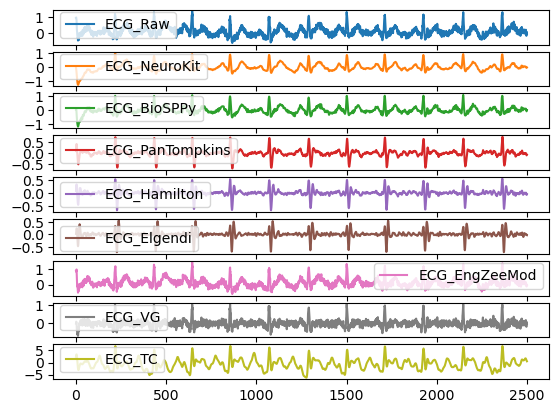

In [ ]:
# Se simula una senal ECG
ecg = nk.ecg_simulate(duration=10, sampling_rate=250, noise=0.2)

ecg += np.random.normal(0, 0.1, len(ecg))  # Ruido Gaussiano

signals = pd.DataFrame({
    "ECG_Raw" : ecg,
    "ECG_NeuroKit" : nk.ecg_clean(ecg, sampling_rate=250, method="neurokit"),
    "ECG_BioSPPy" : nk.ecg_clean(ecg, sampling_rate=250, method="biosppy"),
    "ECG_PanTompkins" : nk.ecg_clean(ecg, sampling_rate=250, method="pantompkins1985"),
    "ECG_Hamilton" : nk.ecg_clean(ecg, sampling_rate=250, method="hamilton2002"),
    "ECG_Elgendi" : nk.ecg_clean(ecg, sampling_rate=250, method="elgendi2010"),
    "ECG_EngZeeMod" : nk.ecg_clean(ecg, sampling_rate=250, method="engzeemod2012"),
    "ECG_VG" : nk.ecg_clean(ecg, sampling_rate=250, method="vg"),
    "ECG_TC" : nk.ecg_clean(ecg, sampling_rate=250, method="templateconvolution")
})


signals.plot(subplots=True)

En la variable `signals` se almacenan cada una de las senales ya filtradas de acuerdo al metodo utilizado, y de este modo seleccionar la senal a trabajar posteriormente

In [ ]:
signals

,ECG_Raw,ECG_NeuroKit,ECG_BioSPPy,ECG_PanTompkins,ECG_Hamilton,ECG_Elgendi,ECG_EngZeeMod,ECG_VG,ECG_TC
0,0.961572,-0.064867,0.030206,0.094016,0.076805,0.015633,0.858348,0.000986,2.350021
1,0.976919,-0.151630,0.062719,0.258719,0.212125,0.069034,0.812075,0.094020,2.937915
2,0.874681,-0.252877,0.001801,0.365834,0.299158,0.147082,0.879883,0.068692,3.299601
3,0.784126,-0.382510,-0.178566,0.411889,0.330679,0.212964,0.954038,0.053832,3.359961
4,0.415939,-0.539363,-0.425017,0.378814,0.290185,0.234868,0.565989,-0.240323,3.087728
...,...,...,...,...,...,...,...,...,...
2495,-0.061670,-0.040709,-0.014719,-0.030810,-0.014040,0.003807,0.060485,-0.093604,1.156510
2496,-0.154511,-0.061912,-0.068013,-0.070944,-0.049166,-0.004493,-0.074562,-0.180770,0.971829
2497,-0.060270,-0.064274,-0.083441,-0.098931,-0.074128,-0.021905,-0.122970,-0.081015,0.791409
2498,0.090354,-0.051075,-0.053337,-0.089008,-0.066653,-0.035797,-0.048383,0.074923,0.640177


## 4. Procesamiento

La función `ecg_process` proporciona una pipeline automatizada para el preprocesamiento de señales ECG. Este método simplifica el análisis al ejecutar automáticamente una serie de pasos fundamentales, que incluyen:

- Limpieza de la señal: Utiliza la función `ecg_clean()` para eliminar ruido y artefactos no deseados.
- Detección de picos: Identifica los picos R en la señal mediante la función `ecg_peaks()`.
- Cálculo de la frecuencia cardíaca: Estima la frecuencia cardíaca con la función `signal_rate()`.
- Evaluación de la calidad de la señal: Determina la calidad de la señal ECG usando `ecg_quality()`.
- Delineación del complejo QRS: Extrae y analiza las características del complejo QRS con `ecg_delineate()`.
- Determinación de fases cardíacas: Clasifica las distintas fases del ciclo cardíaco utilizando `ecg_phase()`.

**Parámetros clave**

- `ecg_signal`: La señal cruda de ECG en formato de lista, arreglo de NumPy o serie de pandas.
- `sampling_rate`: Frecuencia de muestreo de la señal (en Hz). El valor predeterminado es 1000 Hz.
- `method`: Método de procesamiento para la limpieza y detección de picos. Por defecto es 'neurokit', pero también se pueden utilizar otros métodos como '`pantompkins1985`', '`hamilton2002`', '`elgendi2010`' y '`engzeemod2012`'.

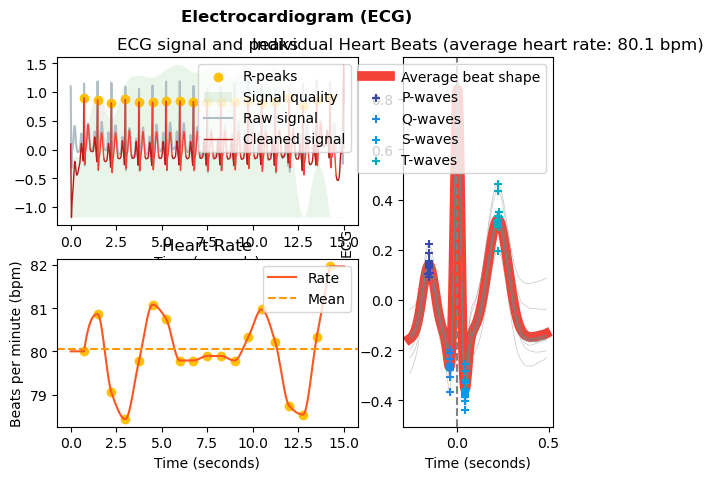

In [ ]:
# Senal ECG simulada
ecg = nk.ecg_simulate(duration=15, sampling_rate=1000, heart_rate=80)

# Preprocesamiento
signals, info = nk.ecg_process(ecg, sampling_rate=1000)

# Visualizacion
nk.ecg_plot(signals, info)

La figura anterior entrga mucha informacion relevante para el analisis de la señal ECG, pero tambien es posible extraer esa informacion para realizar analisis mas especificos.

La variable info, es un diccionario donde se almacenan los diferentes parametros en el flujo de procesamiento. Se puede observar a modo de dataframe de la siguiente manera:

In [ ]:
info_df = pd.DataFrame(list(info.items()), columns=['Metric', 'Value'])
info_df

,Metric,Value
0,method_peaks,neurokit
1,method_fixpeaks,None
2,ECG_R_Peaks,"[733, 1475, 2234, 2999, 3751, 4491, 5234, 5986..."
3,ECG_R_Peaks_Uncorrected,"[733, 1475, 2234, 2999, 3751, 4491, 5234, 5986..."
4,ECG_fixpeaks_ectopic,[]
5,ECG_fixpeaks_missed,[]
6,ECG_fixpeaks_extra,[]
7,ECG_fixpeaks_longshort,[]
8,ECG_fixpeaks_method,kubios
9,ECG_fixpeaks_rr,"[0.75, 0.742, 0.759, 0.765, 0.752, 0.74, 0.743..."


En la variable `signals` es donde se almacenan las diferentes senales resultantes del procesamiento, estas se almacenan a modo de dataframe y se pueden visualizar simplemente ploteandolas.

In [ ]:
signals

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,1.100242,0.097667,80.000000,0.39729,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,1.095237,0.062456,80.000000,0.39729,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,1.083443,0.026992,80.000000,0.39729,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,1.064763,-0.008938,80.000000,0.39729,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,1.039504,-0.045516,80.000000,0.39729,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.246004,0.988084,81.967213,0.00000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
14996,0.187563,0.941819,81.967213,0.00000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
14997,0.130925,0.895039,81.967213,0.00000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
14998,0.076377,0.847930,81.967213,0.00000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


Por ejemplo, si se quiere visualizar unicamente la señal despues del proceso de limpieza

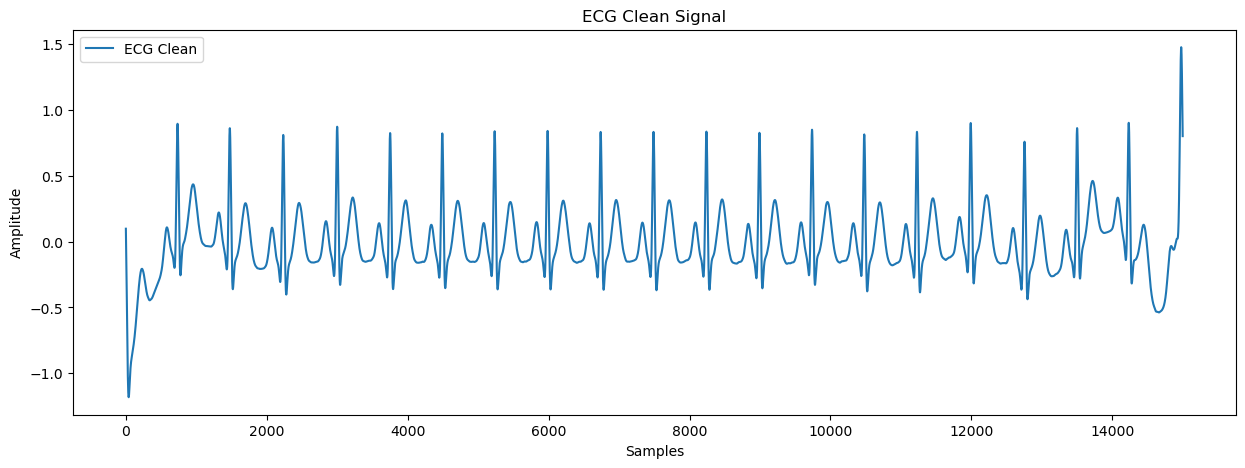

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(signals['ECG_Clean'], label='ECG Clean')
plt.title('ECG Clean Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## 5. Analisis de las señales

La función `ecg_analyze` realiza un análisis automatizado de señales ECG al calcular características relevantes tanto en episodios cortos (análisis relacionado con eventos) como en períodos prolongados (análisis relacionado con intervalos), como en datos de estado en reposo.

**Parámetros principales:**

- `data`: Puede ser un diccionario de épocas (obtenido con `epochs_create()`), un DataFrame con todas las épocas (`epochs_to_df()`), o señales procesadas con `ecg_process()` o `bio_process()`.
- `sampling_rate`: Frecuencia de muestreo en Hz, por defecto 1000 Hz.
- `method`: Determina el enfoque de análisis:
    1. "`event-related`": Para analizar épocas cortas (< 10s).
    2. "`interval-related`": Para períodos largos.
    3. "`auto`": Selección automática según la duración promedio de los datos.

Al implementar esta funcion se devuelve un DataFrame con las características analizadas, incluyendo métricas específicas de eventos o intervalos. Si se realiza un análisis basado en eventos, las épocas estarán identificadas en una columna llamada `Label`.

In [ ]:
# Data
data = nk.data("bio_eventrelated_100hz")

# Procesamiento para un analisis de eventos
df, info = nk.bio_process(ecg=data["ECG"], sampling_rate=100)

events = nk.events_find(data["Photosensor"], threshold_keep='below',
                        event_conditions=["Negative", "Neutral", "Neutral", "Negative"])


epochs = nk.epochs_create(df, events, sampling_rate=100, epochs_start=-0.1, epochs_end=1.9)

# Analisis
analyze_epochs = nk.ecg_analyze(epochs, sampling_rate=100)

# Dataframe
analyze_epochs

,Label,Condition,Event_Onset,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,ECG_Rate_Trend_Linear,ECG_Rate_Trend_Quadratic,ECG_Rate_Trend_R2,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular,ECG_Quality_Mean
1,1,Negative,1024,58.962843,-0.034935,-3.875928,-2.279443,1.114000,0.010553,1.900000,-2.861522,-0.080625,0.999367,0.0,0.144578,1.0,0.400000,0.948597
2,2,Neutral,4957,64.000846,-0.056683,-5.177317,-3.690421,1.654065,0.010553,1.327136,-6.800245,0.283399,0.993256,0.0,0.880000,0.0,0.553846,0.931907
3,3,Neutral,9224,55.976284,4.674856,-1.922230,-0.282846,1.813644,1.900000,1.075879,-7.826192,0.941835,0.956162,0.0,0.044944,1.0,0.133333,0.962712
4,4,Negative,12984,57.505912,-0.010599,-3.800491,-1.378359,1.002110,0.010553,1.900000,-0.248683,-0.171035,0.990209,0.0,0.879518,0.0,0.575342,0.922898


Como se puede ver, se tiene la informacion de los diferentes parametros del ECG relacionados a 4 eventos.

## 6. Variabilidad de la frecuencia cardiaca (HRV)

Esta biblioteca permite calcular indices de variabilidad a partir de los intervalos R-R detectados en la señal ECG, lo que facilita el análisis de la regulación autonómica y su relación con el estrés, la salud cardiovascular y otros aspectos psicológicos.

In [ ]:
data = nk.data("bio_resting_5min_100hz")
data.head()

# Find peaks
peaks, info = nk.ecg_peaks(data["ECG"], sampling_rate=100)

La HRV mide la variación temporal entre latidos consecutivos (intervalos RR). Para calcular los índices de HRV, se usa el resultado de `peaks` como argumento de entrada en funciones específicas de HRV.

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,696.395349,62.135891,10.060728,60.275036,NaN,NaN,NaN,NaN,69.697983,69.779109,...,60.0,0.891502,660.0,740.0,14.651163,49.302326,470.0,1420.0,7.962963,234.375


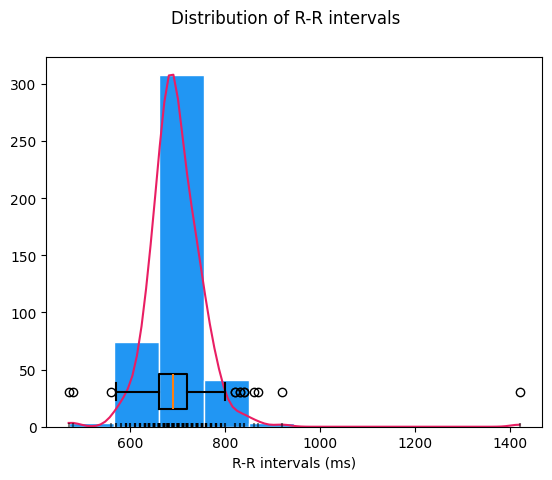

In [ ]:
hrv_time = nk.hrv_time(peaks, sampling_rate=100, show=True)
hrv_time

Entre las características que se pueden calcular se encuentran:

- RMSSD: Raíz cuadrada del promedio de las diferencias al cuadrado entre intervalos RR consecutivos. Es un indicador de la actividad parasimpática del sistema nervioso.
- MeanNN: Promedio de los intervalos RR, que proporciona una medida básica del ritmo cardíaco promedio.
- Y muchas otras métricas relacionadas con la variabilidad en el dominio del tiempo.

### Referencias

[1] NeuroKit2: The Python Toolbox for Neurophysiological Signal Processing. GitHub. Available: https://neuropsychology.github.io/NeuroKit/index.html.[Accessed: 24-Nov-2024].